In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import seaborn as sns
from adjustText import adjust_text
from matplotlib import gridspec
#%matplotlib inline

<ipython-input-14-badb09b02262>:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(15, 10))


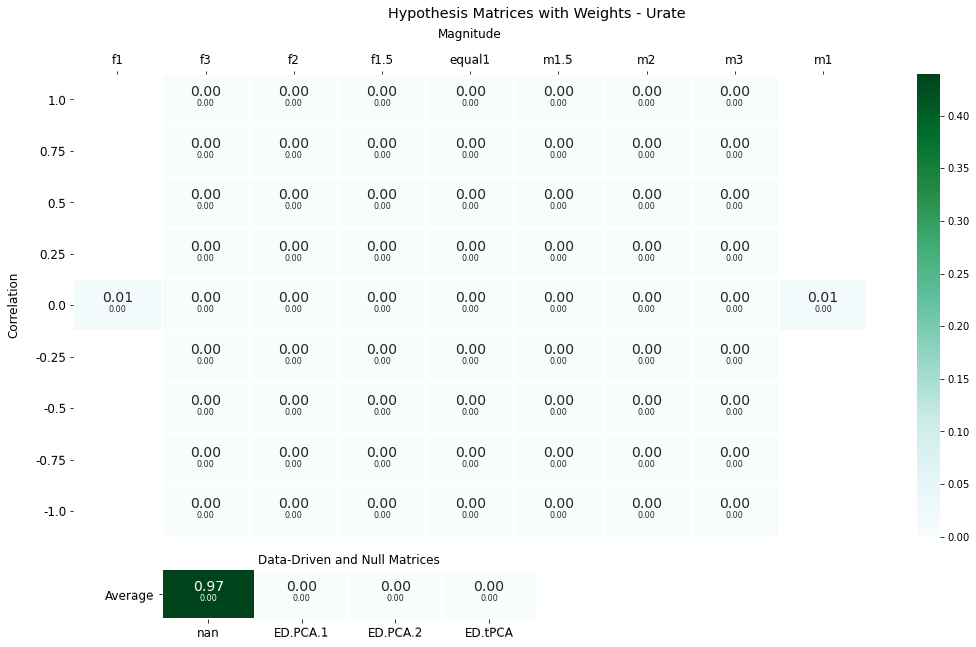

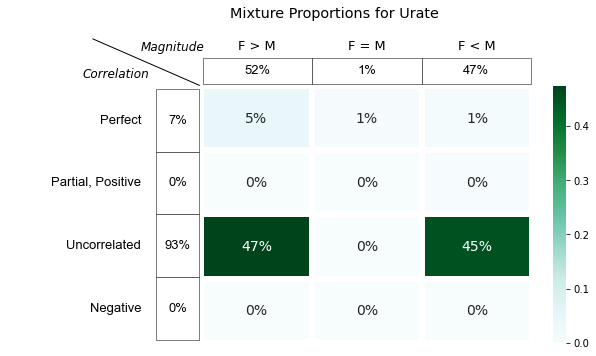

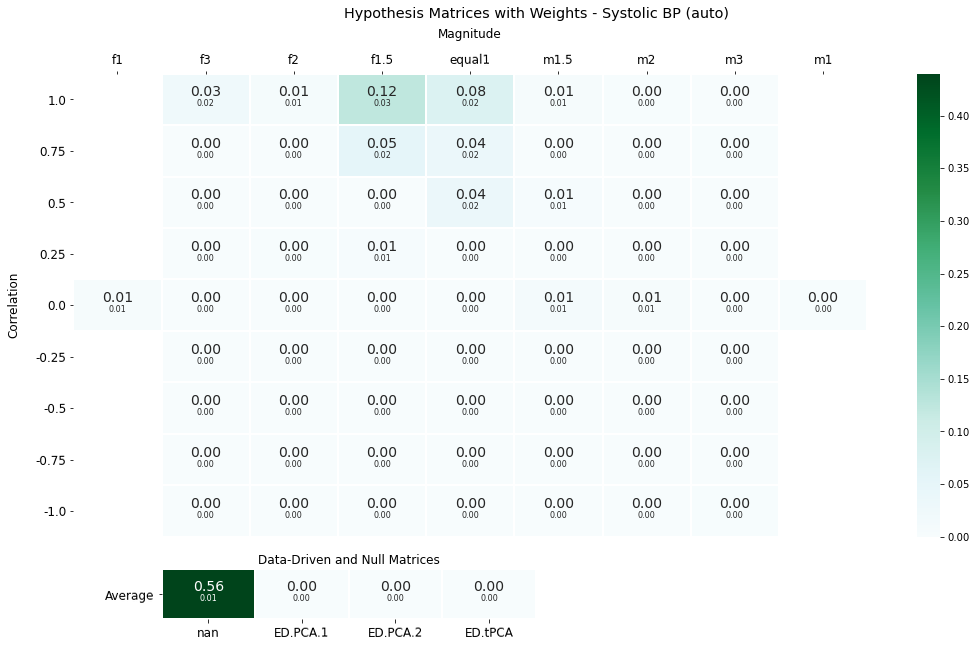

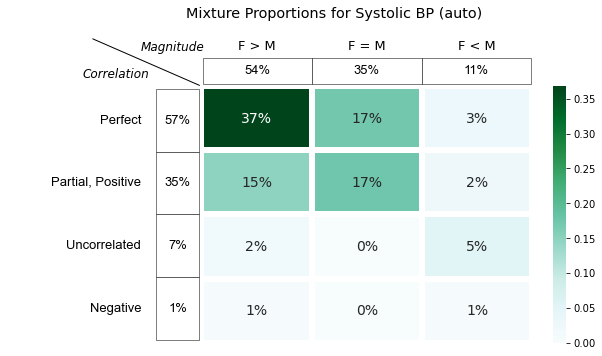

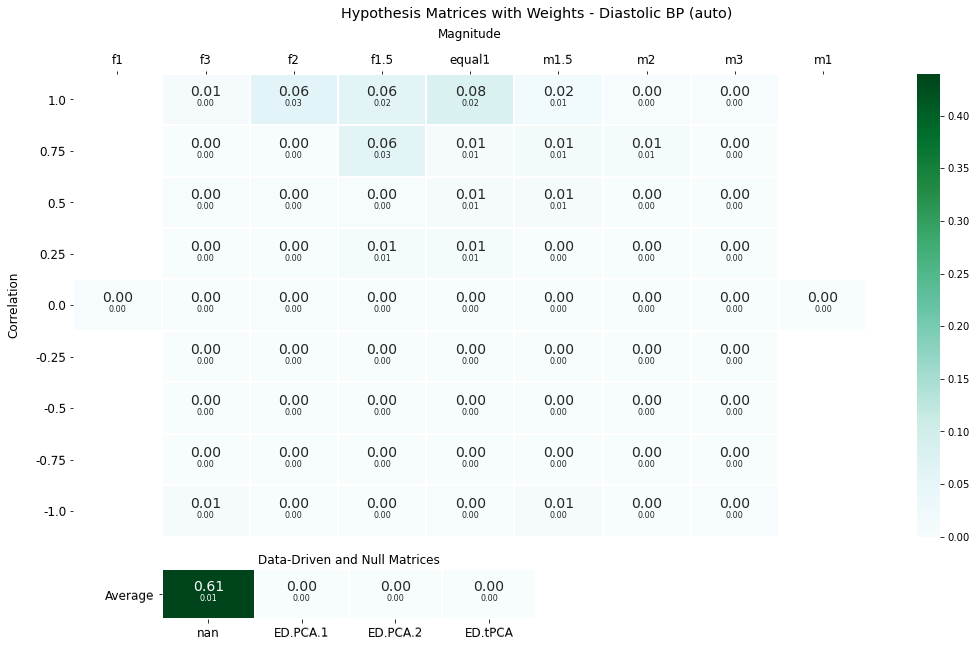

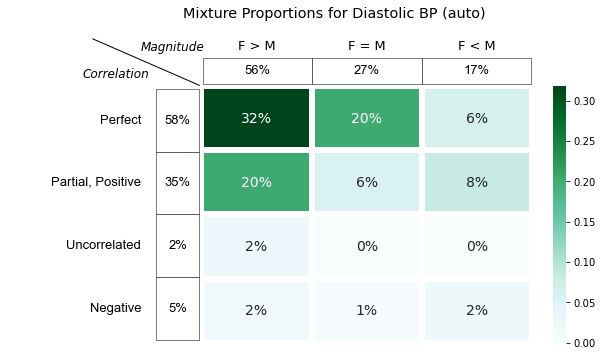

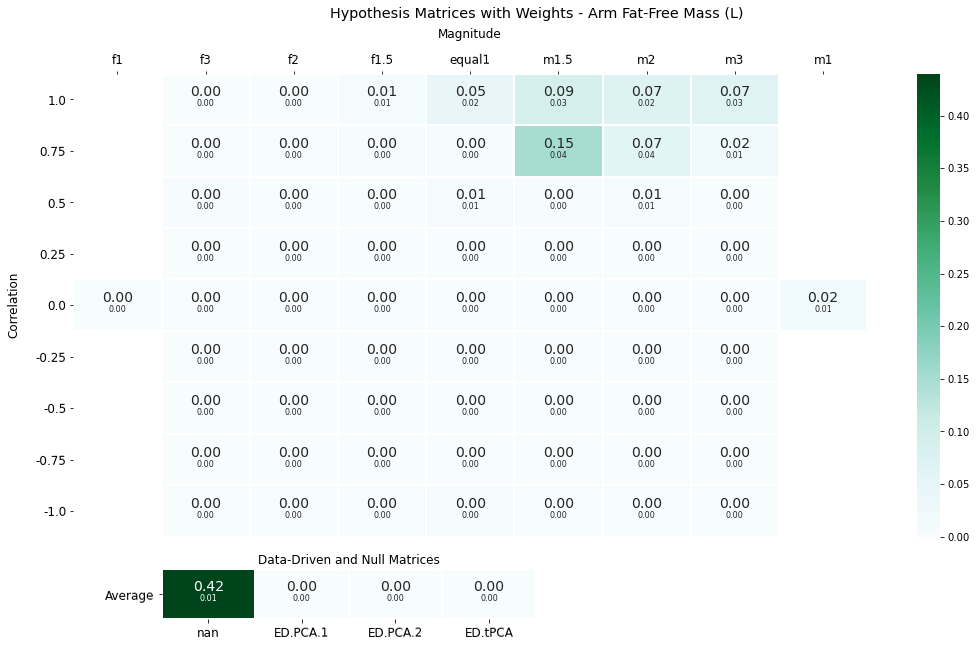

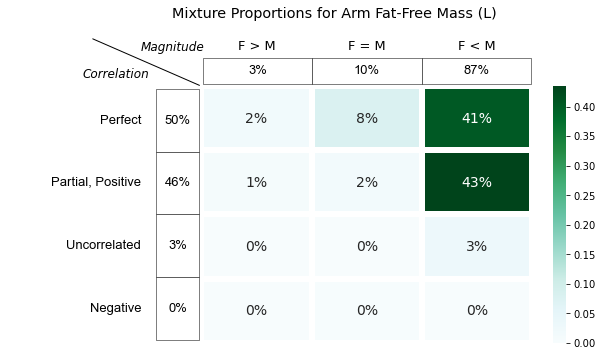

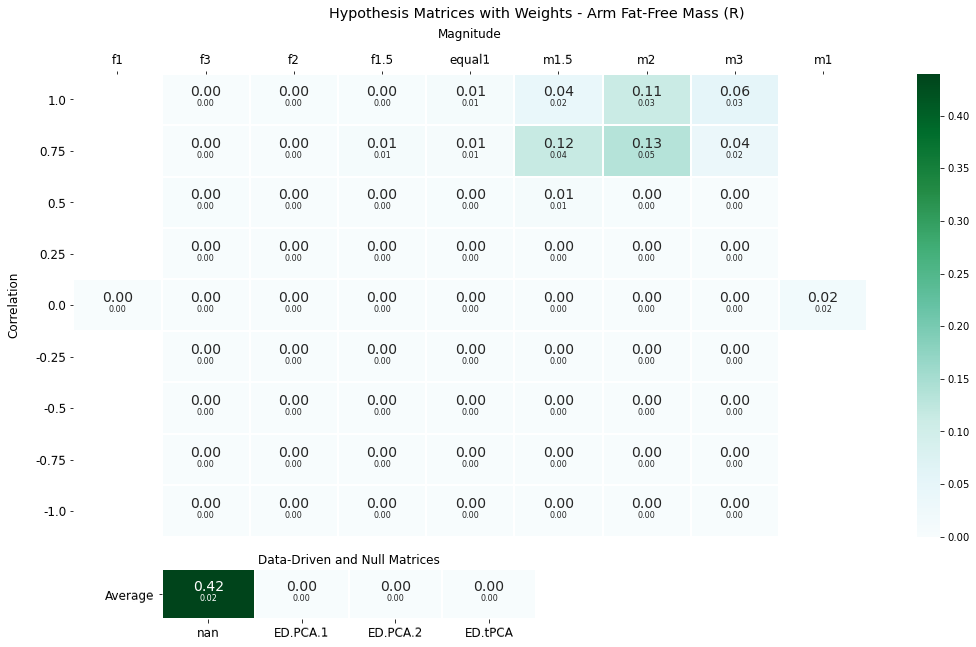

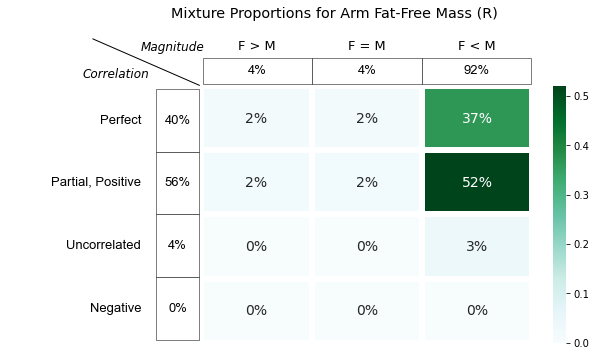

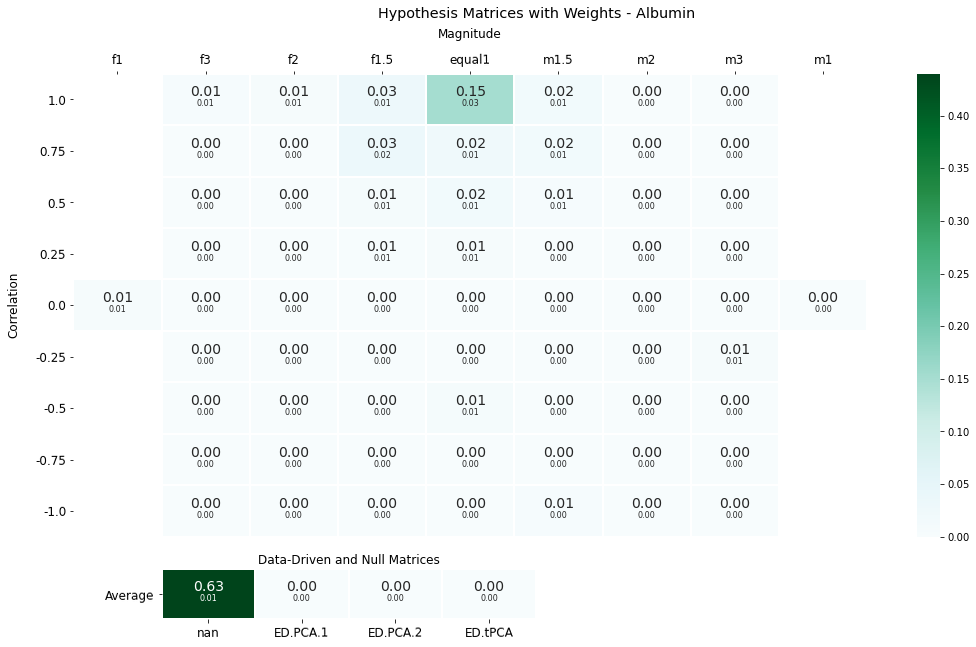

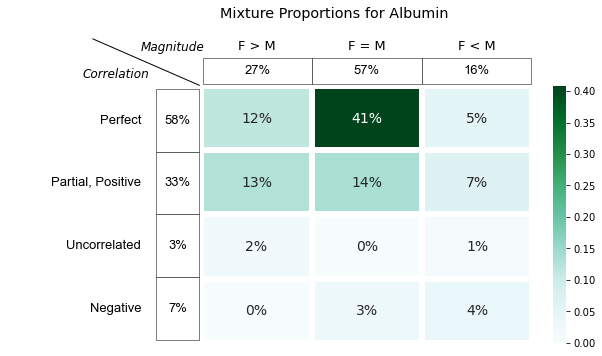

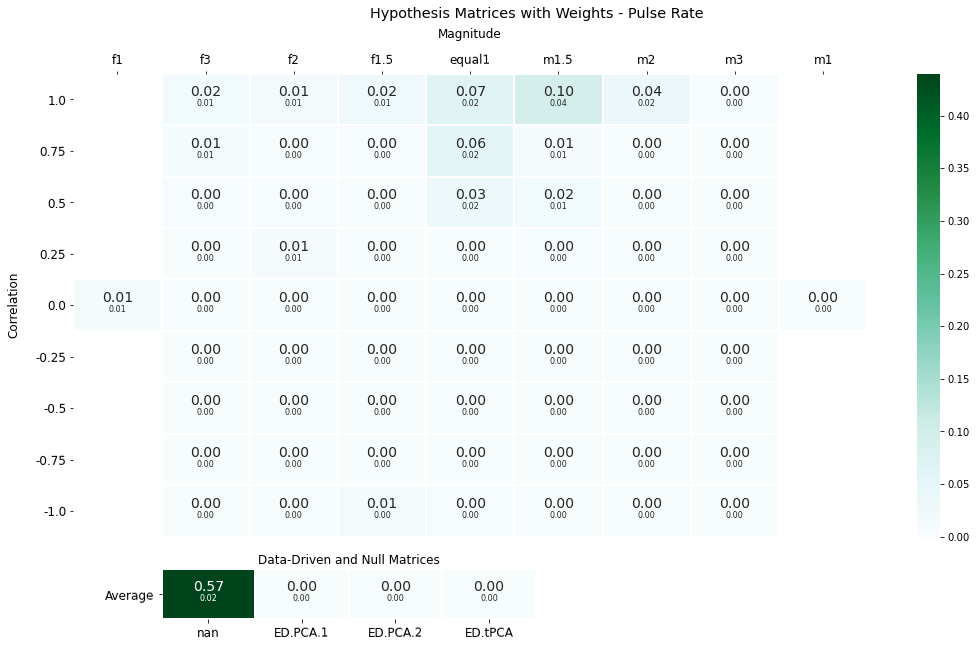

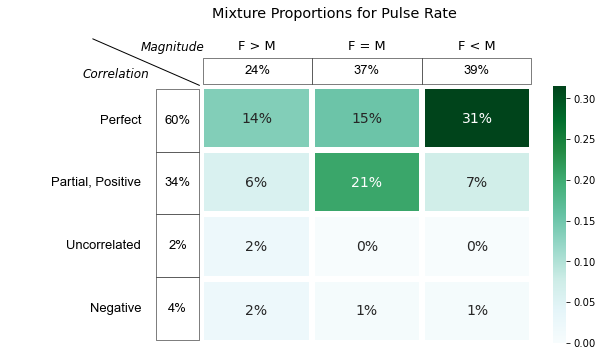

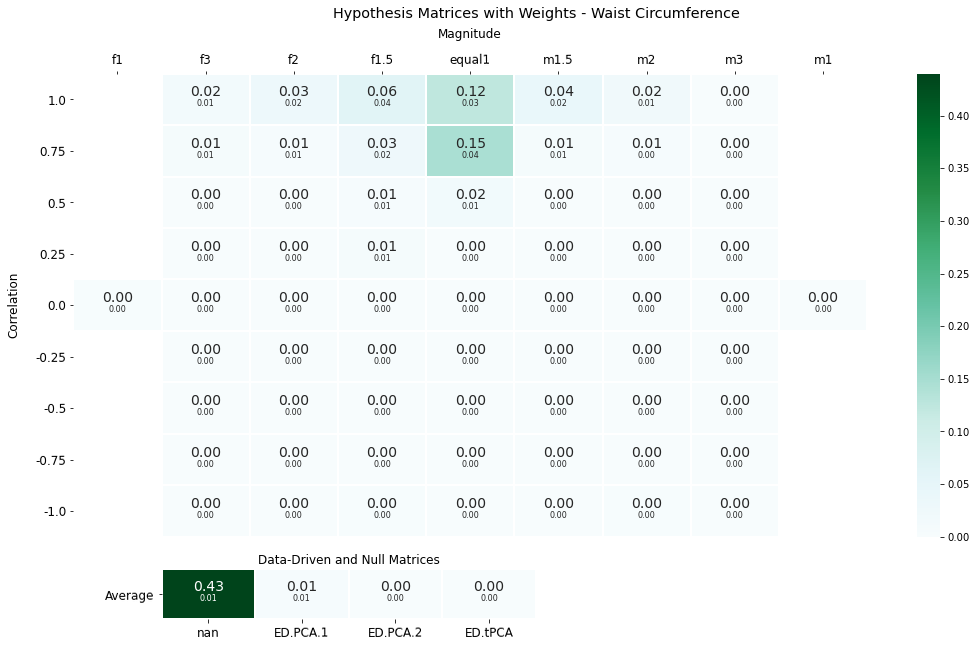

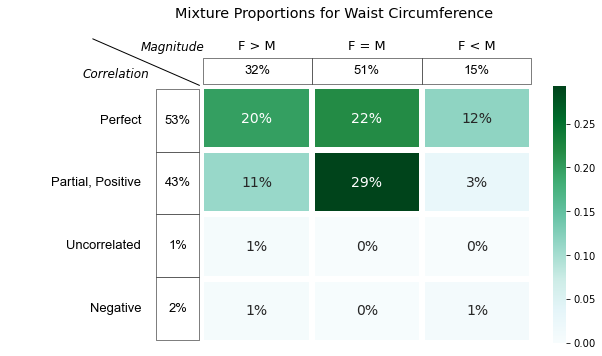

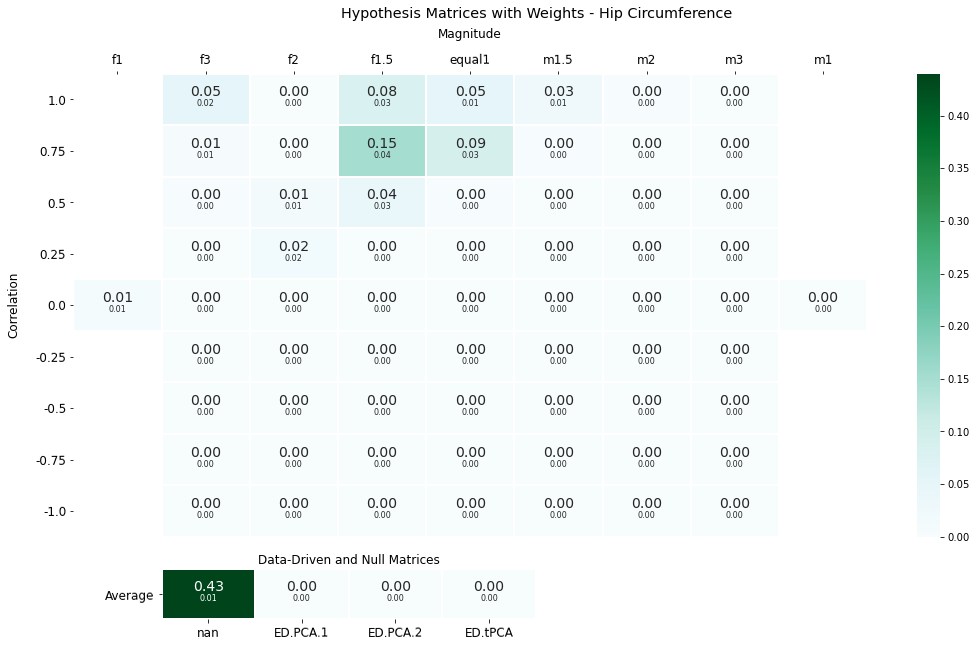

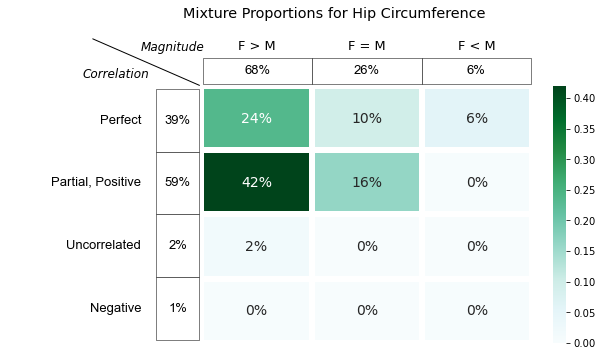

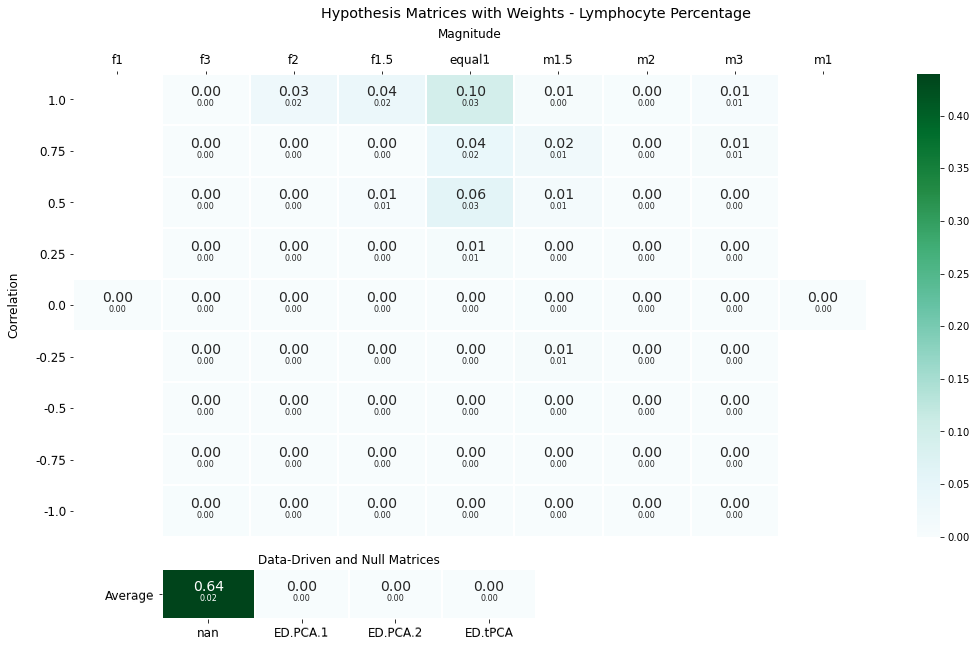

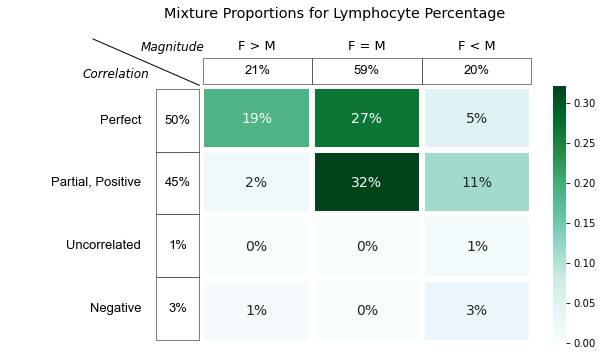

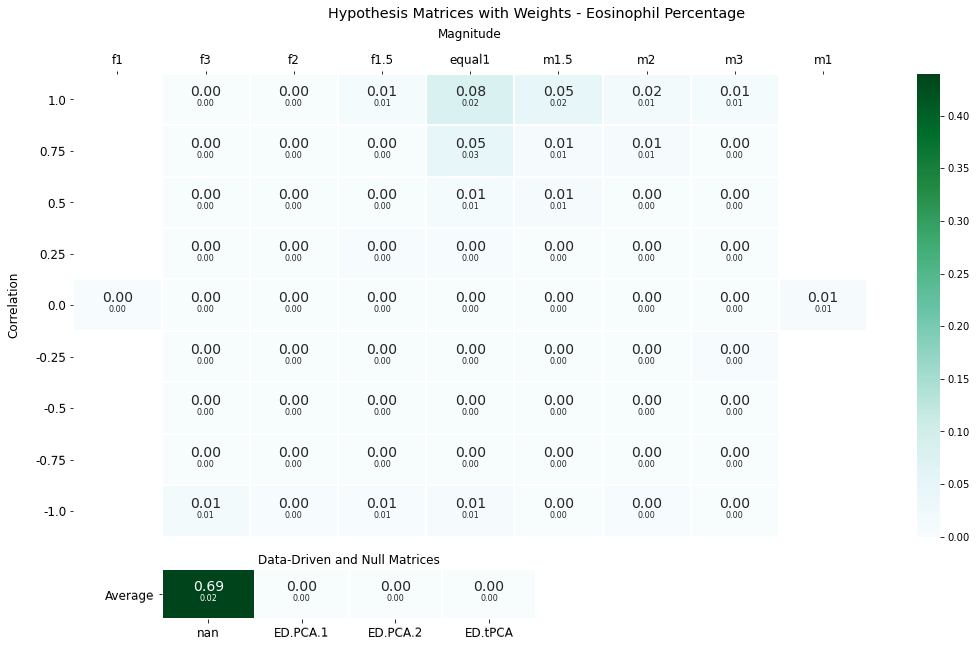

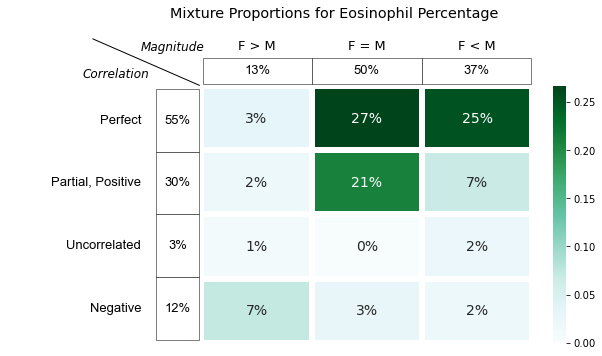

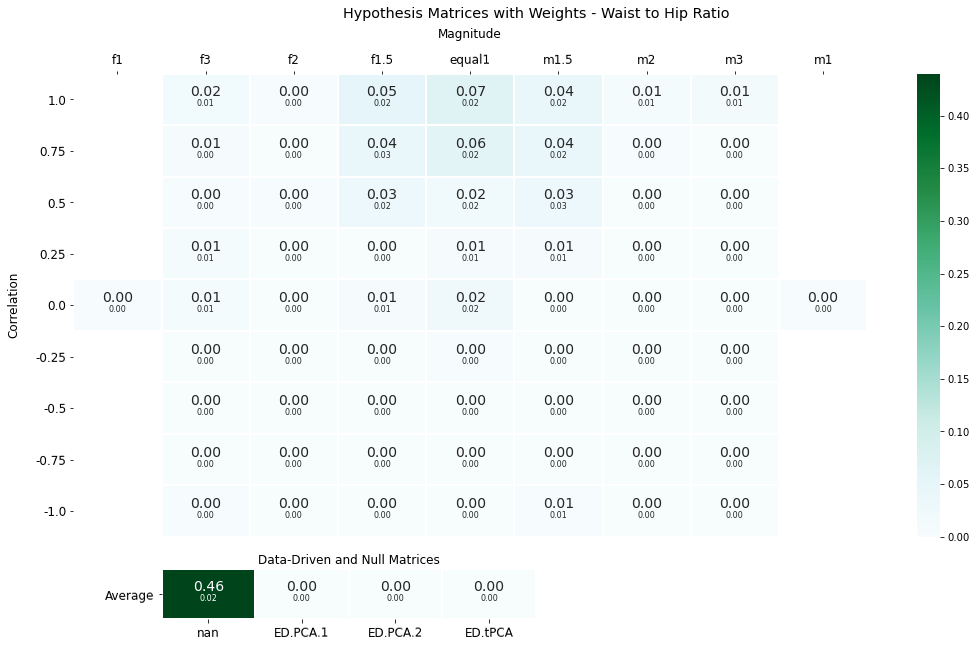

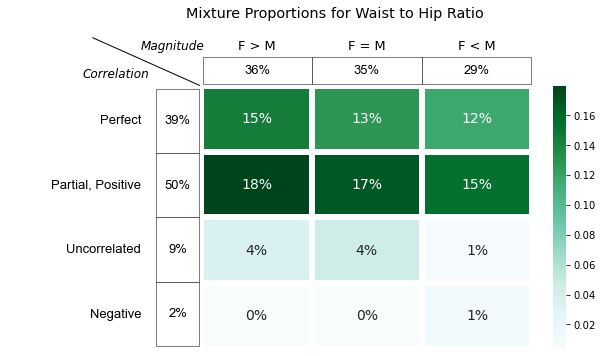

In [17]:
#phenotypes = ['IGF1', 'creatinine', 'RBC_count', 'urea', 'calcium', 'creatinine', 
              #'FVC_best', 'HbA1c', 'protein_total', 'SHBG', 'weight', 'whole_body_fat_mass']
#title = ['IGF-1', 'Creatinine', 'RBC count', 'Urea', 'Calcium', 'Creatinine', 
              #'FVC (best measure)', 'HbA1c', 'Total Protein', 'SHBG', 'Weight', 'Whole Body Fat Mass']
phenotypes = ['urate', 'systolicBP_auto', 'diastolicBP_auto', 'arm_fatfree_mass_L', 'arm_fatfree_mass_R',
             'albumin','pulse_rate','waist_circ','hip_circ','lymphocyte_perc','eosinophil_perc',
              'waist_to_hip']
title = ['Urate', 'Systolic BP (auto)', 'Diastolic BP (auto)', 'Arm Fat-Free Mass (L)', 'Arm Fat-Free Mass (R)',
        'Albumin','Pulse Rate','Waist Circumference','Hip Circumference','Lymphocyte Percentage','Eosinophil Percentage',
         'Waist to Hip Ratio']
#phenotypes = ['height', 'testosterone', 'bmi']
#phenotypes = ['Height', 'Testosterone', 'BMI']
for i in range(len(phenotypes)):
    heatmaps(phenotypes[i], title[i])

In [14]:
def heatmaps(pheno, title):
    # load in mixture proportion results as dataframe
    os.chdir('C:\\Users\\Carrie Zhu\\Documents\\Research\\GWAS-frontera\\GWAS_Results\\{0}'.format(pheno))
    df = pd.read_csv("{0}mixprop_12block.txt".format(pheno),sep="\t")
    
    # get mean and std dev; split matrice name into correlation and effect categories
    df_values = pd.DataFrame({'sem':(df.std(axis=1)/np.sqrt(len(df.columns)-1)),'ave':df.mean(axis=1)})
    df = pd.concat([df['mix_0'], df_values['ave'], df_values['sem']], axis=1)
    split_df = df["mix_0"].str.split("_", n=2, expand = True)
    df['corr'] = split_df[1].astype(float)
    df['effect'] = split_df[0] + split_df[2]
    
    # create pivot table to hypothesis and null matrices for averages and std
    df_hyp = df.loc[pd.notnull(df['effect'])]
    df_ave = df_hyp.pivot(index='corr',columns='effect',values='ave')
    df_ave = df_ave.reindex(columns=['f1','f3', 'f2', 'f1.5','equal1','m1.5','m2','m3','m1'])
    df_ave = df_ave.sort_values('corr', ascending=False)

    df_sem = df_hyp.pivot(index='corr',columns='effect',values='sem')
    df_sem = df_sem.reindex(columns=['f1','f3', 'f2', 'f1.5','equal1','m1.5','m2','m3','m1'])
    df_sem = df_sem.sort_values('corr', ascending=False)

    df_null = df.loc[pd.isnull(df['effect'])]
    df_null_ave = pd.DataFrame(list(df_null['ave']), index=list(df_null['mix_0']), columns=['Average']).T
    df_null_sem = pd.DataFrame(list(df_null['sem']), index=list(df_null['mix_0']), columns=['SEM']).T
    
    # plot heat map
    fig = plt.figure(figsize=(15, 10))
    gs = fig.add_gridspec(8, 12)
    ax1 = fig.add_subplot(gs[0:6,:])
    ax2 = fig.add_subplot(gs[6:7,1:6])

    plt.suptitle("Hypothesis Matrices with Weights - {0}".format(title), fontsize='x-large')
    sns.heatmap(df_ave, cmap='BuGn', annot=True, annot_kws={'size':14, 'va':'bottom'}, linewidths=1, ax=ax1, vmax=0.44, fmt='.2f')
    sns.heatmap(df_ave, cmap='BuGn', annot=df_sem, annot_kws={'size':8, 'va':'top'}, linewidths=1, ax=ax1, vmax=0.44, fmt='.2f',cbar=False)

    ax1.xaxis.tick_top()
    ax1.xaxis.set_label_position('top')
    ax1.set_xlabel('Magnitude',fontsize='large', labelpad=15)
    ax1.set_ylabel('Correlation', fontsize='large', labelpad=15)
    ax1.tick_params(labelsize=12, labelrotation=0.5)

    ax2.set_title("Data-Driven and Null Matrices")
    sns.heatmap(df_null_ave, cmap='BuGn', annot=True, annot_kws={'size':14, 'va':'bottom'}, linewidths=1, ax=ax2, cbar=False, fmt='.2f')
    sns.heatmap(df_null_ave, cmap='BuGn', annot=df_null_sem, annot_kws={'size':8, 'va':'top'}, linewidths=1, ax=ax2, cbar=False, fmt='.2f')
    ax2.tick_params(labelsize=12, labelrotation=0.5)

    plt.tick_params(labelsize=12)

    plt.tight_layout()
    plt.savefig("{0}mixheat_all.pdf".format(pheno))
    
    ## SIMPLIFIED ##
    # create simplied table, proportion based on non-null
    nan_weight = 1 / (1 - df_null.iloc[0]['ave'])
    df_s = df_ave * nan_weight
    f = df_s.filter(regex='f').sum(axis=1)
    equal = df_s.filter(regex='equal').sum(axis=1)
    m = df_s.filter(regex='m').sum(axis=1)
    df_s = pd.DataFrame([f,equal,m], index=['F > M','F = M','F < M']).T
    perfect = df_s.loc[df_s.index.astype(float) == 1].sum()
    partial = df_s.loc[(df_s.index.astype(float) > 0) & (df_ave.index.astype(float) < 1)].sum()
    uncorrelated = df_s.loc[df_s.index.astype(float) == 0].sum()
    negative = df_s.loc[df_s.index.astype(float) < 0].sum()
    df_s = pd.DataFrame([perfect,partial,uncorrelated,negative], index=['perfect','partial','uncorrelated','negative'])

    gender_sum = ['%.0f' % i for i in 100*round(df_s.sum(),2)]
    gender_sum = pd.DataFrame(gender_sum).T
    corr_sum = ['%.0f' % i for i in 100*round(df_s.sum(axis=1),2)]
    corr_sum = pd.DataFrame(corr_sum)
    
    # create simplified heat map with totals table 
    fig, ax = plt.subplots(figsize=(9, 5))
    sns.heatmap(df_s, cmap='BuGn', annot=True, annot_kws={'size':14}, linewidths=5, fmt='.0%', xticklabels=True, yticklabels=False)

    ax.xaxis.tick_top()
    ax.tick_params(axis='x', top=False, pad=30, labelsize='13')
    ax.xaxis.set_label_position('top')

    tbl1 = ax.table(cellText=gender_sum.values+'%', cellLoc='center',
                    bbox=[0.005,1.01,0.99,.1])
    tbl2 = ax.table(cellText=corr_sum.values+'%', rowLabels=['Perfect','Partial, Positive','Uncorrelated','Negative'], rowLoc='right',
                    cellLoc='center', bbox=[-0.26,0.01,.13,0.98])
    tbl1.auto_set_font_size(False)
    tbl2.auto_set_font_size(False)
    tbl2.auto_set_column_width(False)
    for i in range(4):
        tbl2.get_celld()[(i,0)].set_text_props(fontfamily='Arial', fontsize='13')
        tbl2.get_celld()[(i,0)].set_linewidth(0.5)
        tbl2.get_celld()[(i,-1)].set_text_props(fontfamily='Arial', fontsize='13')
        tbl2.get_celld()[(i,-1)].visible_edges = ''
    for c in tbl1.get_celld().values():
        c.set_text_props(fontfamily='Arial', fontsize='13')
        c.set_linewidth(0.5)
    ax.text(-1.08,-0.13,'Correlation',fontdict={'size':'large', 'style':'italic'})
    ax.text(-0.55,-0.55,'Magnitude',fontdict={'size':'large', 'style':'italic'})
    plt.suptitle("Mixture Proportions for {0}".format(title), fontsize='x-large', x=0.55)
    plt.annotate("",xy=(0,0),xytext=(-1,-0.75),color='black', arrowprops={'arrowstyle':'-'})

    plt.tight_layout()
    plt.savefig("{0}mixheat_small.pdf".format(pheno))